# Setup

In [1]:
%reload_ext nb_black
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
# Function for determining Confidence Intervals
def ci_95(x1, x2):
    signal = x1.mean() - x2.mean()
    noise = np.sqrt(x1.var() / x1.size + x2.var() / x2.size)

    ci_lo = signal - 1.96 * noise
    ci_hi = signal + 1.96 * noise

    return ci_lo, ci_hi

<IPython.core.display.Javascript object>

In [83]:
# Function for merging Dataframes by year
def merge_fun(year_df, year):
    df = pd.DataFrame()
    add_columns = []
    for i in merge_columns:
        add_columns.extend(x for x in year_df.columns if i in x)
    df[merge_columns] = year_df[add_columns]
    df["Happiness Score"] = year_df[[x for x in year_df.columns if "Score" in x]]
    df["Year"] = year
    df = df.set_index(["Country", "Year"])
    return df

<IPython.core.display.Javascript object>

# Exploring the data

In [3]:
# Load in 2019 DataFrame
url = "https://raw.githubusercontent.com/WoodyBurns44/Happiness_index_Analysis/main/2019.csv"
df_2019 = pd.read_csv(url)

<IPython.core.display.Javascript object>

In [4]:
df_2019.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


<IPython.core.display.Javascript object>

In [5]:
# See what data we're working with
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Overall rank                  156 non-null    int64  
 1   Country or region             156 non-null    object 
 2   Score                         156 non-null    float64
 3   GDP per capita                156 non-null    float64
 4   Social support                156 non-null    float64
 5   Healthy life expectancy       156 non-null    float64
 6   Freedom to make life choices  156 non-null    float64
 7   Generosity                    156 non-null    float64
 8   Perceptions of corruption     156 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 11.1+ KB


<IPython.core.display.Javascript object>

In [6]:
df_2019.shape

(156, 9)

<IPython.core.display.Javascript object>

In [7]:
df_2019.index

RangeIndex(start=0, stop=156, step=1)

<IPython.core.display.Javascript object>

In [8]:
df_2019.columns

Index(['Overall rank', 'Country or region', 'Score', 'GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption'],
      dtype='object')

<IPython.core.display.Javascript object>

In [9]:
df_2019.describe()

,Overall rank,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,78.500000,5.407096,0.905147,1.208814,0.725244,0.392571,0.184846,0.110603
std,45.177428,1.113120,0.398389,0.299191,0.242124,0.143289,0.095254,0.094538
min,1.000000,2.853000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.750000,4.544500,0.602750,1.055750,0.547750,0.308000,0.108750,0.047000
50%,78.500000,5.379500,0.960000,1.271500,0.789000,0.417000,0.177500,0.085500
75%,117.250000,6.184500,1.232500,1.452500,0.881750,0.507250,0.248250,0.141250
max,156.000000,7.769000,1.684000,1.624000,1.141000,0.631000,0.566000,0.453000


<IPython.core.display.Javascript object>

# Is there a correlation between the GDP per capita in 2019 for the happiest and less happy countries? If so, how strong is the correlation? 

## Divide the dataset into two groups: happy countries and less happy Countries based on the median happiness score. 

In [10]:
# Split by median to get as close to equal sized data as possible
median = df_2019["Score"].median()

<IPython.core.display.Javascript object>

In [11]:
# Select the "Happiest" countries, above the median
happy_2019 = df_2019[df_2019["Score"] > median]

<IPython.core.display.Javascript object>

In [12]:
happy_2019.shape

(78, 9)

<IPython.core.display.Javascript object>

In [13]:
# Select the less happy countries, below the median
unhappy_2019 = df_2019[df_2019["Score"] <= median]

<IPython.core.display.Javascript object>

In [14]:
unhappy_2019.shape

(78, 9)

<IPython.core.display.Javascript object>

In order to determine which test will most accurately find whether there is a correlation or not, I must look into the distribution of the data. First, I will test both variables for normality. 

## Test for normality 

In [15]:
# Find the mean and medians of the data sets to see if they tell us anything abou ttheir normality
happy_2019["GDP per capita"].mean()

1.1753205128205129

<IPython.core.display.Javascript object>

In [16]:
happy_2019["GDP per capita"].median()

1.234

<IPython.core.display.Javascript object>

In [17]:
unhappy_2019["GDP per capita"].mean()

0.6349743589743589

<IPython.core.display.Javascript object>

In [18]:
unhappy_2019["GDP per capita"].median()
# The means and medians of both samples are fairly close to eachother, which is an indication
# that the data might be normally distributed.

0.615

<IPython.core.display.Javascript object>

In [19]:
# Check the Kurtosis and Skewness
stats.describe(unhappy_2019["GDP per capita"])

DescribeResult(nobs=78, minmax=(0.0, 1.2209999999999999), mean=0.634974358974359, variance=0.10823560972360974, skewness=-0.08290870711598033, kurtosis=-1.1498978910868107)

<IPython.core.display.Javascript object>

In [20]:
stats.describe(happy_2019["GDP per capita"])

DescribeResult(nobs=78, minmax=(0.493, 1.6840000000000002), mean=1.1753205128205129, variance=0.06337102580752581, skewness=-0.5745889547501999, kurtosis=-0.22799964801593386)

<IPython.core.display.Javascript object>

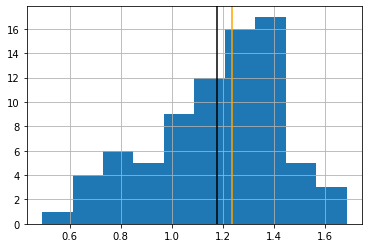

<IPython.core.display.Javascript object>

In [21]:
# Histogram of the GDP per capita of happy countries, with a black line showing the mean
# and an orange line showing the median.
happy_2019["GDP per capita"].hist()
plt.axvline(x=happy_2019["GDP per capita"].median(), c="orange", linestyle="solid")
plt.axvline(x=happy_2019["GDP per capita"].mean(), c="black", linestyle="solid")
plt.show()

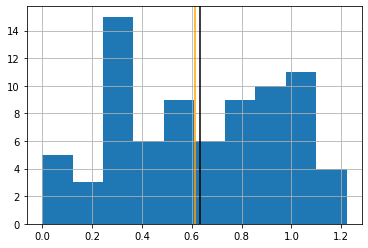

<IPython.core.display.Javascript object>

In [22]:
# Histogram of the GDP per capita of less happy countries, with a black line showing the mean
# and an orange line showing the median.
unhappy_2019["GDP per capita"].hist()
plt.axvline(x=unhappy_2019["GDP per capita"].median(), c="orange", linestyle="solid")
plt.axvline(x=unhappy_2019["GDP per capita"].mean(), c="black", linestyle="solid")
plt.show()

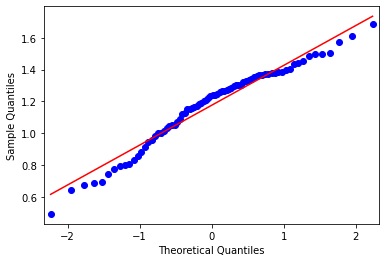

<IPython.core.display.Javascript object>

In [23]:
## QQ plot to visualize happy countries GDP per capita relation to normal distribution
qqplot(happy_2019["GDP per capita"], line="s")
plt.show()

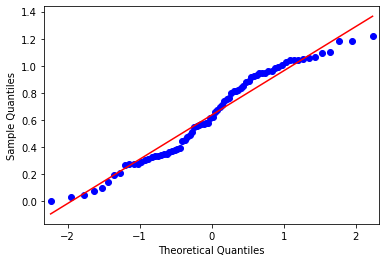

<IPython.core.display.Javascript object>

In [24]:
## QQ plot to visualize less happy countries Happiness scores relation to normal distribution
qqplot(unhappy_2019["GDP per capita"], line="s")
plt.show()

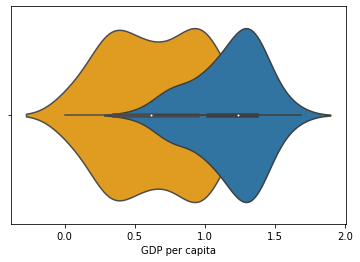

<IPython.core.display.Javascript object>

In [25]:
# Check normality with a Violin plot
sns.violinplot(x="GDP per capita", data=unhappy_2019, color="orange")
sns.violinplot(x="GDP per capita", data=happy_2019)
plt.show()

In [26]:
j, p = stats.jarque_bera(unhappy_2019["GDP per capita"])

<IPython.core.display.Javascript object>

In [27]:
j

4.386721868062523

<IPython.core.display.Javascript object>

In [28]:
p < 0.05

False

<IPython.core.display.Javascript object>

The result of the Jarque-Bera test indicates that the distribution is not perectly normal. However, since the sample size is small and all of the other tests indicate normality, I will treat it as normal. 

Since both happy and less happy countries GDP per capita appear to be normal, I will perform a Students T-test to determine if there is variance between the groups. 

## Student T-Test 

The Students T-test is used to detect if the means are different between two groups. 
* $H_o$ : Both developing and developed countries have the same mean of GDP per capita
* $H_a$ : The mean of GDP per capita differs between developing and developed countries 

In [29]:
ttest_score, ttest_p = stats.ttest_ind(
    happy_2019["GDP per capita"], unhappy_2019["GDP per capita"]
)

<IPython.core.display.Javascript object>

In [30]:
ttest_score, ttest_p

(11.519995979115722, 1.5400383543520562e-22)

<IPython.core.display.Javascript object>

In [31]:
ttest_p < 0.05

True

<IPython.core.display.Javascript object>

The Students  T-test indicates that the null hypothesis can be rejected and that the distribution of GDP per capita differs between happy and less happy countries. 

## How significant is the difference in GDP per capita between the happiest and less happy countries?

In order to determine the difference in means between happy and less happy countries' GDP per Capital I will calculate a confidence interval and then bootstrap to test that calculation.

In [32]:
# Calculating low and high confidence intervals using function defined above
ci_95(happy_2019["GDP per capita"], unhappy_2019["GDP per capita"])

(0.44841222752721815, 0.6322800801650897)

<IPython.core.display.Javascript object>

I can say with 95% confidence that there is a .45 and .63 difference in the GDP per Capita of happy and less happy countries, in favor of the more happy countries.  

In [33]:
# Testing confidence interval with a bootstrap

mean_diffs = []
for i in range(10000):
    control_sample = happy_2019["GDP per capita"].sample(frac=1.0, replace=True)
    treatment_sample = unhappy_2019["GDP per capita"].sample(frac=1.0, replace=True)
    mean_diff = control_sample.mean() - treatment_sample.mean()
    mean_diffs.append(mean_diff)

<IPython.core.display.Javascript object>

In [34]:
low_ci = np.percentile(mean_diffs, 2.5)
high_ci = np.percentile(mean_diffs, 97.5)

<IPython.core.display.Javascript object>

In [35]:
low_ci, high_ci

(0.4496394230769232, 0.6328298076923078)

<IPython.core.display.Javascript object>

The sample bootstrapping confirms my calculations that there is, with 95% certainty, a .45 and .63 difference in the GDP per Capita of happy and less happy countries, in favor of the more happy countries.

# Has the happiness of the world changed from 2015 to 2019? If so, in what way and how much? 

## Investigate the DataFrame for 2015 data

In [36]:
# Use Pandas to import the 2015 Dataframe
url_2015 = "https://raw.githubusercontent.com/WoodyBurns44/Happiness_index_Analysis/main/2015.csv"
df_2015 = pd.read_csv(url_2015)

<IPython.core.display.Javascript object>

In [37]:
df_2015.head()

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


<IPython.core.display.Javascript object>

In [38]:
df_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Country                        158 non-null    object 
 1   Region                         158 non-null    object 
 2   Happiness Rank                 158 non-null    int64  
 3   Happiness Score                158 non-null    float64
 4   Standard Error                 158 non-null    float64
 5   Economy (GDP per Capita)       158 non-null    float64
 6   Family                         158 non-null    float64
 7   Health (Life Expectancy)       158 non-null    float64
 8   Freedom                        158 non-null    float64
 9   Trust (Government Corruption)  158 non-null    float64
 10  Generosity                     158 non-null    float64
 11  Dystopia Residual              158 non-null    float64
dtypes: float64(9), int64(1), object(2)
memory usage: 1

<IPython.core.display.Javascript object>

In [39]:
df_2015.describe()

,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,79.493671,5.375734,0.047885,0.846137,0.991046,0.630259,0.428615,0.143422,0.237296,2.098977
std,45.754363,1.145010,0.017146,0.403121,0.272369,0.247078,0.150693,0.120034,0.126685,0.553550
min,1.000000,2.839000,0.018480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328580
25%,40.250000,4.526000,0.037268,0.545808,0.856823,0.439185,0.328330,0.061675,0.150553,1.759410
50%,79.500000,5.232500,0.043940,0.910245,1.029510,0.696705,0.435515,0.107220,0.216130,2.095415
75%,118.750000,6.243750,0.052300,1.158448,1.214405,0.811013,0.549092,0.180255,0.309883,2.462415
max,158.000000,7.587000,0.136930,1.690420,1.402230,1.025250,0.669730,0.551910,0.795880,3.602140


<IPython.core.display.Javascript object>

In [40]:
df_2015.columns

Index(['Country', 'Region', 'Happiness Rank', 'Happiness Score',
       'Standard Error', 'Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity', 'Dystopia Residual'],
      dtype='object')

<IPython.core.display.Javascript object>

## Isolate the Happiness columns for 2015 and 2019

In [41]:
# Create Dataframes for the 2015 and 2019 data
happy15 = df_2015["Happiness Score"]
# happy15.head()
happy15.index

RangeIndex(start=0, stop=158, step=1)

<IPython.core.display.Javascript object>

In [42]:
happy19 = df_2019["Score"]
# happy19.head()
happy19.index

RangeIndex(start=0, stop=156, step=1)

<IPython.core.display.Javascript object>

## Test for normality of happiness in 2015 and 2019

### 2015

In [43]:
happy15.mean()

5.3757341772151905

<IPython.core.display.Javascript object>

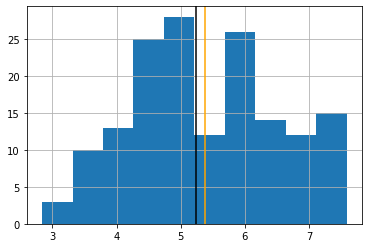

<IPython.core.display.Javascript object>

In [44]:
happy15.hist()
plt.axvline(x=happy15.mean(), c="orange")
plt.axvline(x=happy15.median(), c="black")
plt.show()

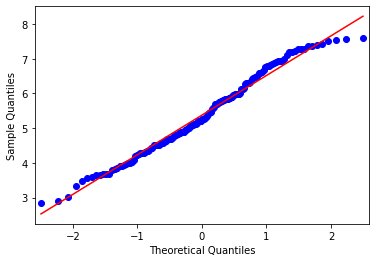

<IPython.core.display.Javascript object>

In [45]:
qqplot(happy15, line="s")
plt.show()

Use the Jarque-Bera test for normality
* $H_o$ : The data comes from a normally distributed set. 
* $H_a$ : The data does not come form a normally distributed set. 

In [46]:
j15, p15 = stats.jarque_bera(happy15)

<IPython.core.display.Javascript object>

In [47]:
j15

4.35007318564233

<IPython.core.display.Javascript object>

In [48]:
p15

0.11360399650397524

<IPython.core.display.Javascript object>

In [49]:
p < 0.05

False

<IPython.core.display.Javascript object>

Since we cannot reject the null, it can be assumed that the data comes from a normal distribution. 

### 2019

In [50]:
happy19.mean()

5.407096153846153

<IPython.core.display.Javascript object>

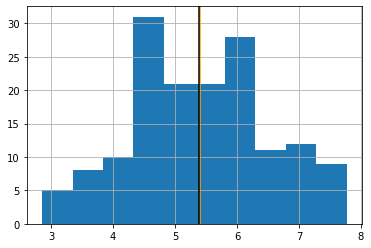

<IPython.core.display.Javascript object>

In [51]:
happy19.hist()
plt.axvline(x=happy19.mean(), c="orange")
plt.axvline(x=happy19.median(), c="black")
plt.show()

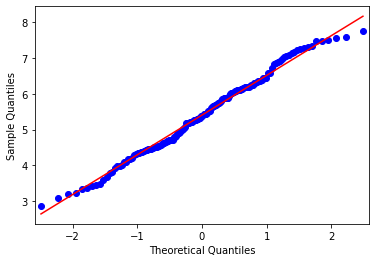

<IPython.core.display.Javascript object>

In [52]:
qqplot(happy19, line="s")
plt.show()

In [53]:
j19, p19 = stats.jarque_bera(happy19)

<IPython.core.display.Javascript object>

In [54]:
j19

2.5608576817581676

<IPython.core.display.Javascript object>

In [55]:
p19

0.2779180922553508

<IPython.core.display.Javascript object>

Since we cannot reject the null, it can be assumed that the data comes from a normal distribution.

## Perform an independent T-test

In [56]:
t_15_to_19, p_15_to_19 = stats.ttest_ind(happy15, happy19)

<IPython.core.display.Javascript object>

In [57]:
t_15_to_19

-0.24605256185513566

<IPython.core.display.Javascript object>

In [58]:
p_15_to_19

0.8058033345552673

<IPython.core.display.Javascript object>

## Result

There does not appear to be a significant diffance in the overall happiness of the world in 2019 as compared with 2015. 

# Which factors are most strongly correlated to the overall happiness score in 2019?

Make a Spearman Correlatoin matrix to test for correlations between all numeric categories

In [59]:
spearman_correlations = df_2019.corr(method="spearman")
spearman_correlations

,Overall rank,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
Overall rank,1.000000,-0.999999,-0.814430,-0.816125,-0.807279,-0.552014,-0.070484,-0.217240
Score,-0.999999,1.000000,0.814483,0.816181,0.807275,0.551974,0.070483,0.217348
GDP per capita,-0.814430,0.814483,1.000000,0.768539,0.851513,0.393426,-0.041304,0.223203
Social support,-0.816125,0.816181,0.768539,1.000000,0.725997,0.449491,0.007695,0.114017
Healthy life expectancy,-0.807279,0.807275,0.851513,0.725997,1.000000,0.412906,-0.006773,0.165309
Freedom to make life choices,-0.552014,0.551974,0.393426,0.449491,0.412906,1.000000,0.324146,0.403586
Generosity,-0.070484,0.070483,-0.041304,0.007695,-0.006773,0.324146,1.000000,0.286171
Perceptions of corruption,-0.217240,0.217348,0.223203,0.114017,0.165309,0.403586,0.286171,1.000000


<IPython.core.display.Javascript object>

Translate matrix into a heatmap for better visualization of the correlations. 

* code for heatmap inspired by Jesper Dramsch on Kaggle (https://www.kaggle.com/jesperdramsch/the-reason-we-re-happy). 

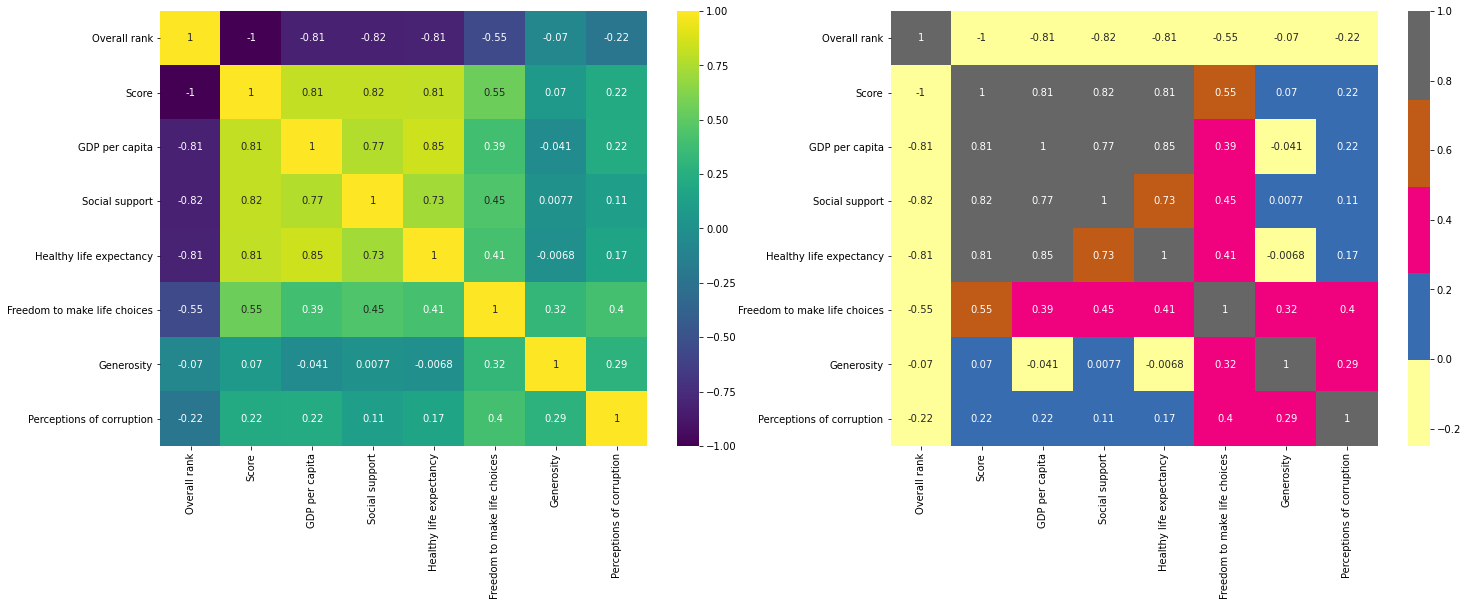

<IPython.core.display.Javascript object>

In [60]:
fig, ax = plt.subplots(ncols=2, figsize=(24, 8))
sns.heatmap(
    spearman_correlations,
    vmin=-1,
    vmax=1,
    ax=ax[0],
    center=0,
    cmap="viridis",
    annot=True,
)
sns.heatmap(
    spearman_correlations,
    vmin=-0.25,
    vmax=1,
    ax=ax[1],
    center=0,
    cmap="Accent",
    annot=True,
    linecolor="white",
)

The heat map gives us a lot of information, including:
* Validates that there is a strong correlation between GDP per capita and happiness score
* Shows that there is very strong correlation between the following fields and the happiness score:
    * Social Support
    * Healthy Life Expectancy 
    * Freedom to make Life choices

# Appendix: Further Exploration 

In [61]:
url_2016 = "https://raw.githubusercontent.com/WoodyBurns44/Happiness_index_Analysis/main/2016.csv"
url_2017 = "https://raw.githubusercontent.com/WoodyBurns44/Happiness_index_Analysis/main/2017.csv"
url_2018 = "https://raw.githubusercontent.com/WoodyBurns44/Happiness_index_Analysis/main/2018.csv"

<IPython.core.display.Javascript object>

In [62]:
df_2016 = pd.read_csv(url_2016)
df_2017 = pd.read_csv(url_2017)
df_2018 = pd.read_csv(url_2018)

<IPython.core.display.Javascript object>

In [63]:
df_2016.head(1)

,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Denmark,Western Europe,1,7.526,7.46,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939


<IPython.core.display.Javascript object>

In [64]:
df_2015.head(1)

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738


<IPython.core.display.Javascript object>

In [65]:
# Template Columns for merging table

merge_columns = [
    "Country",
    "GDP",
    "Family",
    "Life",
    "Freedom",
    "Generosity",
    "Trust",
]

<IPython.core.display.Javascript object>

In [66]:
# Format 2015 Dataframe
df = merge_fun(df_2015, 2015)

<IPython.core.display.Javascript object>

In [67]:
# Format and merge 2016 Dataframe
df = df.append(merge_fun(df_2016, 2016), sort=False)

<IPython.core.display.Javascript object>

In [68]:
# Format and Merge 2017 Dataframe
df = df.append(merge_fun(df_2017, 2017), sort=False)

<IPython.core.display.Javascript object>

In [69]:
# Rename columns in 2018 Datframe so that they work with merge function
df_2018 = df_2018.rename(
    columns={
        "Healthy life expectancy": "Life",
        "Perceptions of corruption": "Trust",
        "Social support": "Family",
    },
)

<IPython.core.display.Javascript object>

In [70]:
# Merge 2018 Dataframe
df = df.append(merge_fun(df_2018, 2018), sort=False)

<IPython.core.display.Javascript object>

In [71]:
# Rename 2019 columns so that they work with merge function
df_2019 = df_2019.rename(
    columns={
        "Social support": "Family",
        "Healthy life expectancy": "Life",
        "Perceptions of corruption": "Trust",
    }
)

<IPython.core.display.Javascript object>

In [72]:
# Merge 2019 Dataframe
df = df.append(merge_fun(df_2019, 2019), sort=False)

<IPython.core.display.Javascript object>

In [73]:
df.head()

,,GDP,Family,Life,Freedom,Generosity,Trust,Happiness Score
Country,Year,,,,,,,
Switzerland,2015,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978,7.587
Iceland,2015,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145,7.561
Denmark,2015,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357,7.527
Norway,2015,1.45900,1.33095,0.88521,0.66973,0.34699,0.36503,7.522
Canada,2015,1.32629,1.32261,0.90563,0.63297,0.45811,0.32957,7.427


<IPython.core.display.Javascript object>

In [77]:
df = df.rename(columns={"Happiness Score": "Happiness_Score"})

<IPython.core.display.Javascript object>

In [78]:
# Reset Index for plotability 
df_test = df.reset_index()

<IPython.core.display.Javascript object>

In [79]:
df_test.head()

,Country,Year,GDP,Family,Life,Freedom,Generosity,Trust,Happiness_Score
0,Switzerland,2015,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978,7.587
1,Iceland,2015,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145,7.561
2,Denmark,2015,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357,7.527
3,Norway,2015,1.45900,1.33095,0.88521,0.66973,0.34699,0.36503,7.522
4,Canada,2015,1.32629,1.32261,0.90563,0.63297,0.45811,0.32957,7.427


<IPython.core.display.Javascript object>

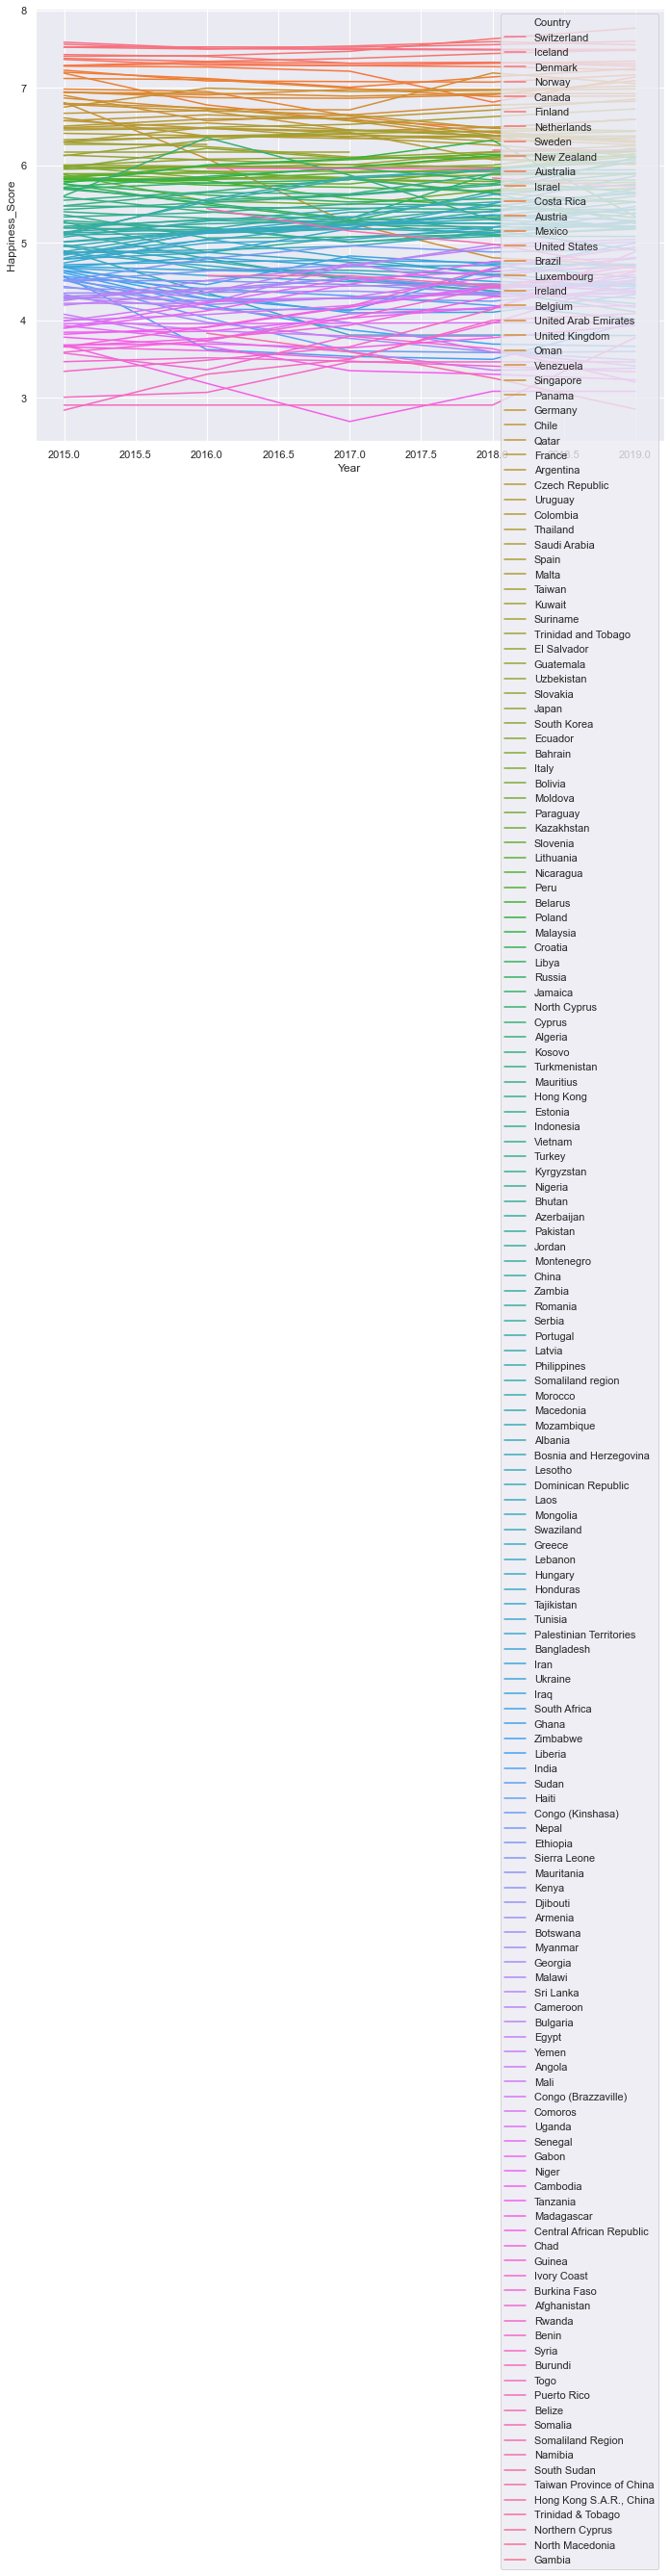

<IPython.core.display.Javascript object>

In [81]:
# Plot yearly change of Happiness Score for insights
sns.set(rc={"figure.figsize": (11.7, 8.27)})
happy_plot = sns.lineplot(
    x="Year",
    y="Happiness_Score",
    hue="Country",
    legend="brief",
    data=df_test,
)
# happy_plot.legend(loc=10)